#Info 
This notebook is to create a new CSV file "Studies.csv" with the following  columns :


*   PatientID : extracted from Dicom_info 
*   P_ID : extracted from PatientID and has the notation "P_int" it's used to lookup pathology from calc and mass
*   full,Roi,Cropped images Path 
*   Pathology
*   studyNo : Index for each Study

This file will collect mamogramme images from our directory and assign a ROI mask and pathology information to each image from the collected data.



**MOUNTING GOOGLE DRIVE**

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Collecting data from CSV files


each patient ID is a unique study that should have full , ROI and cropped


*   first by locating a mamogramm
*   finding in corresponding masks that has the same M_ID as a slice of dataframe
*   then adding each pair row of masks as row by iterating over the slice of a dataframe found 
*   finaly we will collect the pathology from calc and mass 

![illustration](https://drive.google.com/uc?export=view&id=1VcU1w0LIWROqhxpVy_CHv6wtkBQ51Kkg)



*   **reading the required dataframes and initializing Studies**


In [ ]:
import pandas as pd
DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"

dicom = pd.read_csv(f'{DDSM_dir}/csv_mod/dicom_info_mod.csv')
calc =  pd.read_csv(f'{DDSM_dir}/csv_mod/calc_case_description.csv')
mass =  pd.read_csv(f'{DDSM_dir}/csv_mod/mass_case_description.csv')

*   **collecting data from dicom**

In [ ]:
import re
from tqdm import tqdm
p_id_pattern = r'P_\d+'
m_id_pattern = r'P_\d+_\w+_[A-Z]+'

studies = pd.DataFrame(columns=['StudyNo','M_ID','P_ID','mammogram_path','ROI_path','cropped_path','pathology'])

count = 1 

mam_entries = dicom[dicom['SeriesDescription'] == "full mammogram images"]

df_list= []
for index, row in tqdm(mam_entries.iterrows()):

  PatientID = row['PatientID']
  P_ID = re.findall(p_id_pattern, PatientID)[0]
  M_ID = re.findall(m_id_pattern,PatientID)[0]

  mammogram_path = row['image_path']
  roi_path = None
  cropped_path = None

  masks_df = dicom[((dicom['SeriesDescription'] == "ROI mask images") | (dicom['SeriesDescription'] == "cropped images")) & (dicom['PatientID'].str.contains(M_ID))]
  

  for PatientID in masks_df.groupby('PatientID').groups:
    roi_df = masks_df[(masks_df['PatientID'] == PatientID) & (masks_df['SeriesDescription'] == "ROI mask images")]

    if len(roi_df) > 0:
      roi_path = roi_df['image_path'].iloc[0]

    cropped_df = masks_df[(masks_df['PatientID'] == PatientID) & (masks_df['SeriesDescription'] == "cropped images")]
    if len(cropped_df) > 0:
      cropped_path = cropped_df['image_path'].iloc[0]

    new_studyRow = {'StudyNo' : count ,'M_ID' : M_ID,'P_ID' : P_ID , 'mammogram_path' : mammogram_path, 'ROI_path' : roi_path, 'cropped_path' : cropped_path }
    df_list.append(new_studyRow)
    count = count+1

studies = pd.DataFrame.from_records(df_list)

3103it [00:31, 98.36it/s] 


*   **collecting pathology from calc and mass**

In [ ]:
for index, studyRow in tqdm(studies.iterrows()):

    calc_row = calc[calc['patient_id'] == studyRow['P_ID']]
    mass_row = mass[mass['patient_id'] == studyRow['P_ID']]
    pathology = None

    if not calc_row.empty:
      pathology = calc_row['pathology'].iloc[0]
        
    elif not mass_row.empty:
      pathology = mass_row['pathology'].iloc[0]

    studies.loc[index, 'pathology'] = pathology

4093it [00:05, 789.37it/s]


In [ ]:
studies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4093 entries, 0 to 4092
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   StudyNo         4093 non-null   int64 
 1   M_ID            4093 non-null   object
 2   P_ID            4093 non-null   object
 3   mammogram_path  4093 non-null   object
 4   ROI_path        3751 non-null   object
 5   cropped_path    4093 non-null   object
 6   pathology       4093 non-null   object
dtypes: int64(1), object(6)
memory usage: 224.0+ KB


The number of ROI images and Cropped images are higher than expected , we might have some redundancy

In [ ]:
print(len(dicom[(dicom['SeriesDescription'] == "ROI mask images")]))
print(len(dicom[(dicom['SeriesDescription'] == "cropped images")]))

3567
3567


#Resolving Redundancy

 a function to plot each row

In [ ]:
### Function definition ####
import matplotlib.pyplot as plt
import random
import cv2

def plot_studies(Files):

  n = len(Files)

  fig, ax = plt.subplots(n, 3, figsize=(12, n*3))
  fig.subplots_adjust(hspace=0.3, wspace=0.01)
  plt.setp(ax, xticks=[], yticks=[])

  for i, row in tqdm(Files.reset_index().iterrows()):
    mamogram = cv2.resize(cv2.imread(row['mammogram_path']), dsize=(512,512))
    ax[i, 0].imshow(mamogram)
    if row['ROI_path'] is not None:
      roi = cv2.resize(cv2.imread(row['ROI_path'] ), dsize=(512,512))
      ax[i, 1].imshow(roi)

    if row['cropped_path'] is not None:
      cropped = cv2.resize(cv2.imread(row['cropped_path']), dsize=(512,512))
      ax[i, 2].imshow(cropped)

    ax[i, 1].set_title(row['pathology'], fontsize=12, y=-0.2)
    
  plt.show()

*   ***Droping ROI duplicates***



In [ ]:
df = studies.dropna(subset= ['ROI_path','cropped_path'])
duplicates = df[df.duplicated(subset = ['ROI_path','cropped_path'], keep = False)]
print(len(duplicates))

366


visually checking before deleting duplectes

2it [00:00,  3.88it/s]


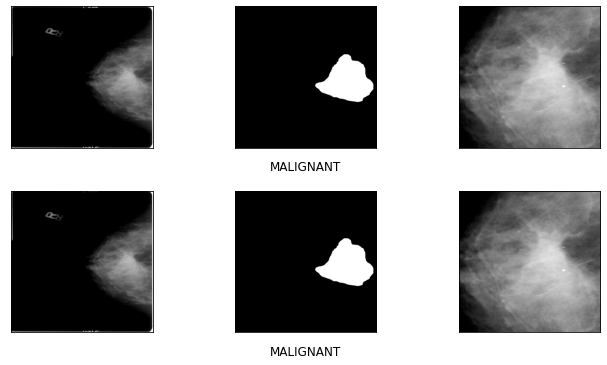

2it [00:00,  4.10it/s]


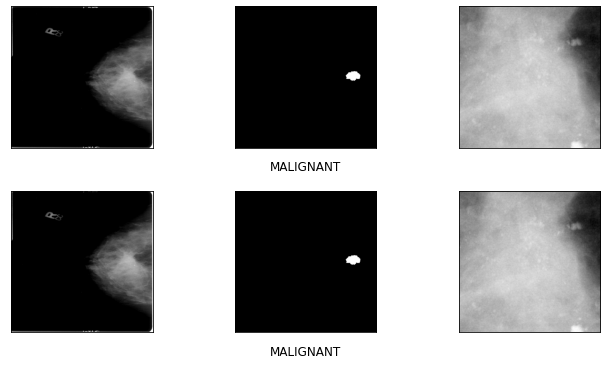

In [ ]:
for val in duplicates['ROI_path'].unique()[:2]: # first 2 duplicates
  plot_studies(duplicates[(duplicates['ROI_path']== val)])

In [ ]:
df = studies.dropna(subset= ['ROI_path','cropped_path'])
duplicates_mask = df.duplicated(subset = ['ROI_path','cropped_path'])
drop_df = studies[studies.isin(df[duplicates_mask]).all(axis = 1)]
studies = studies.drop(drop_df.index)
studies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3910 entries, 0 to 4092
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   StudyNo         3910 non-null   int64 
 1   M_ID            3910 non-null   object
 2   P_ID            3910 non-null   object
 3   mammogram_path  3910 non-null   object
 4   ROI_path        3568 non-null   object
 5   cropped_path    3910 non-null   object
 6   pathology       3910 non-null   object
dtypes: int64(1), object(6)
memory usage: 244.4+ KB



*  **Dropping Cropped duplicates**

In [ ]:
df = studies.dropna(subset= ['cropped_path'])
duplicates = df[df.duplicated(subset = ['cropped_path'], keep = False)]
print(len(duplicates))

646


2it [00:00,  5.35it/s]


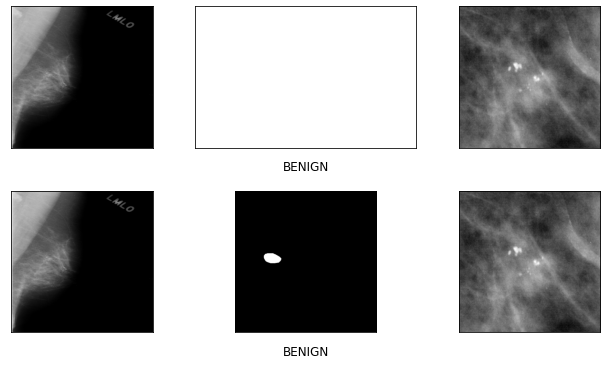

2it [00:00,  3.23it/s]


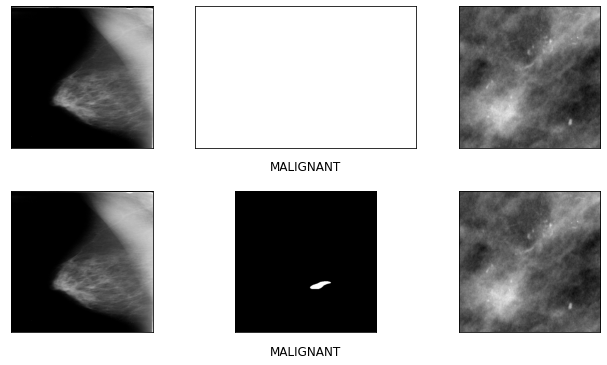

3it [00:00,  4.38it/s]


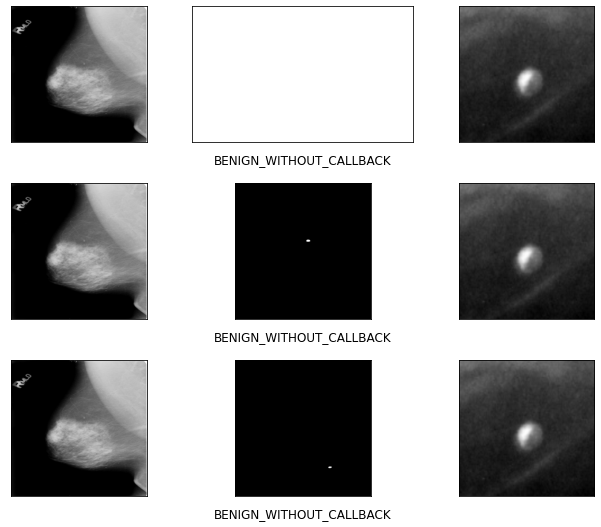

In [ ]:
for val in duplicates['cropped_path'].unique()[:3]: # first 2 duplicates
  plot_studies(duplicates[(duplicates['cropped_path']== val)])

we found out that some rows does not have a ROI mask , but it's specified in another row for the same mamogram. 
We will delete these rows

In [ ]:
null_rows = duplicates[duplicates[duplicates['M_ID'].duplicated(keep=False)].isnull().any(axis=1)]
drop_df = studies[studies.isin(null_rows).any(axis = 1)]
print(len(drop_df))
studies = studies.drop(drop_df.index)

306



*   **we still have repeated cropped images**

some studies have the same cropped image repeated more than once, even though it's a different mask, this can increase the overfitting if we include the cropped images into our model.

we will consider removing them if we will consider using the cropped images on our models.


In [ ]:
(studies['cropped_path'].value_counts() > 1).sum()

51

#Summery

*   We collected all the scattered data into studies.csv.
*   We managed to collect ***3604*** studies, each with its own mammogram, ROI, and cropped image, after resolving redundant values.
*   The number of mammogram photos is ***3032***.
*   The total number of studies is ***3604***, which is higher since some mammograms have more than one ROI mask, thus more than one study.
*   There are ***36*** mammograms that do not have an ROI mask.
*   There are ***51*** cropped images that are redundant but will be considered later on.






In [ ]:
studies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3604 entries, 0 to 4092
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   StudyNo         3604 non-null   int64 
 1   M_ID            3604 non-null   object
 2   P_ID            3604 non-null   object
 3   mammogram_path  3604 non-null   object
 4   ROI_path        3568 non-null   object
 5   cropped_path    3604 non-null   object
 6   pathology       3604 non-null   object
dtypes: int64(1), object(6)
memory usage: 225.2+ KB


In [ ]:
studies['mammogram_path'].nunique()

3032

In [ ]:
studies['ROI_path'].isnull().sum()

36

3it [00:00,  4.54it/s]


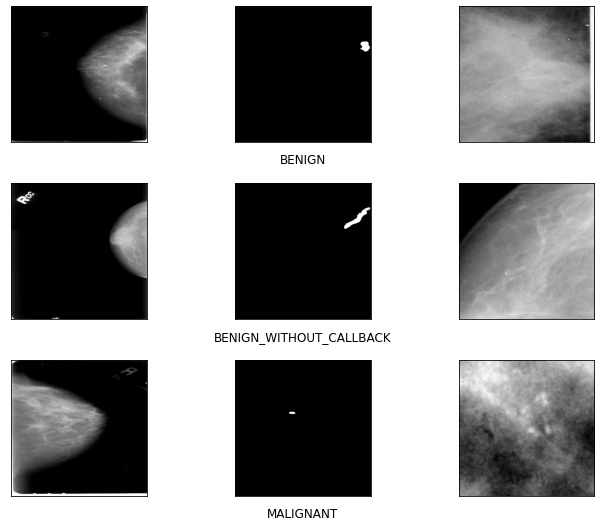

In [ ]:
sample_df = studies.groupby('pathology').apply(lambda x: x.sample(n=1, random_state=1)).reset_index(drop=True)
plot_studies(sample_df)

***Exporting into drive directory***

In [ ]:
studies.to_csv("/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM/csv_mod/studies.csv")